<a href="https://colab.research.google.com/github/SiriBatchu/CMPE-257/blob/main/Colabs/Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
file_path = "/content/HouseData_CA_Complete.csv"  # Update if needed
df = pd.read_csv(file_path)

# Select relevant features
numerical_features = ['sqft', 'beds', 'full_baths', 'list_price']
categorical_features = ['style', 'status']

# Convert numerical columns to float (fix string issue)
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, set errors as NaN

# Drop rows with missing values (after conversion)
df_cleaned = df[numerical_features + categorical_features].dropna()

# Encode categorical variables
le = LabelEncoder()
for col in categorical_features:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

# Split into features (X) and target (y)
X = df_cleaned.drop(columns=['list_price'])  # Predictors
y = df_cleaned['list_price']  # Target variable

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data preparation complete. Numerical features converted successfully.")


✅ Data preparation complete. Numerical features converted successfully.


# Feature Importance

Feature Importance Ranking:
       Feature  Importance
0        sqft    0.874214
3       style    0.040367
2  full_baths    0.031952
1        beds    0.028521
4      status    0.024946


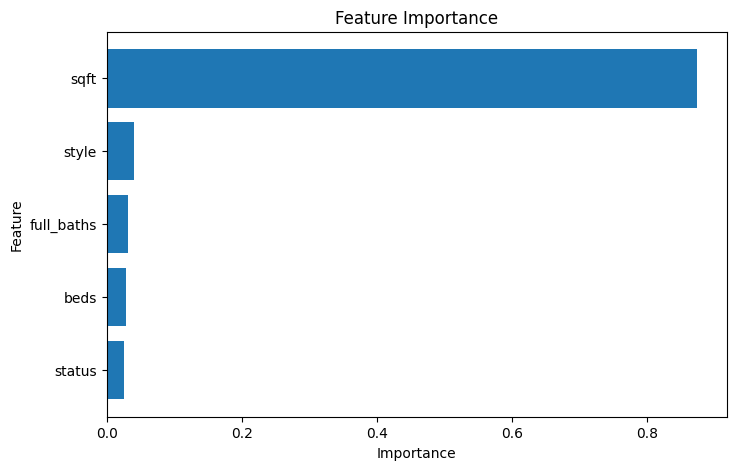

✅ Most Important Feature: sqft


In [2]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Train a RandomForestRegressor to find feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importance Ranking:\n", feature_importance_df)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Identify the most important feature
most_important_feature = feature_importance_df.iloc[0]['Feature']
print(f"✅ Most Important Feature: {most_important_feature}")


# Data distribution (Upsampling & Downsampling)

In [3]:
import numpy as np
from sklearn.utils import resample

# Function to upsample the most important feature
def upsample_feature(data, feature, scale_factor=1.5):
    """ Increases the range of the selected feature by duplicating samples and adding noise. """
    upsampled_data = data.copy()

    # Duplicate and modify values
    upsampled_samples = resample(data, replace=True, n_samples=int(len(data) * scale_factor), random_state=42)
    upsampled_samples[feature] *= np.random.uniform(1.1, 1.5, len(upsampled_samples))

    return pd.concat([data, upsampled_samples])

# Function to downsample the most important feature
def downsample_feature(data, feature, scale_factor=0.5):
    """ Reduces the range of the selected feature by removing samples. """
    downsampled_data = resample(data, replace=False, n_samples=int(len(data) * scale_factor), random_state=42)
    return downsampled_data

# Example: Modify the distribution of sqft
modified_data_upsampled = upsample_feature(df_cleaned, most_important_feature)
modified_data_downsampled = downsample_feature(df_cleaned, most_important_feature)

print(f"✅ Data distribution modification complete for {most_important_feature}.")
print(f"Upsampled Data Size: {len(modified_data_upsampled)}, Downsampled Data Size: {len(modified_data_downsampled)}")


✅ Data distribution modification complete for sqft.
Upsampled Data Size: 37395, Downsampled Data Size: 7479


# Data converted to classification categories

In [4]:
import numpy as np

# Convert list_price into categories (Low, Medium, High)
df_cleaned['price_category'] = pd.qcut(df_cleaned['list_price'], q=3, labels=['Low', 'Medium', 'High'])

# Use this new categorical column as the target variable
X_classification = df_cleaned.drop(columns=['list_price', 'price_category'])
y_classification = df_cleaned['price_category']

# Split data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

print("✅ Data converted to classification categories.")


✅ Data converted to classification categories.


# Model Training & Müller Loop Model Performance

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Function to train models and compute performance metrics
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)  # Using R² as the metric
        results[name] = score

    return results

# Define models for the Müller loop
models = {
    "MLP": MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=500, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "SVM": SVR()
}

# Train and evaluate on the original dataset
print("Training on Original Data...")
original_results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

# Train and evaluate on upsampled data
print("Training on Upsampled Data...")
upsampled_X = modified_data_upsampled.drop(columns=['list_price'])
upsampled_y = modified_data_upsampled['list_price']
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(upsampled_X, upsampled_y, test_size=0.2, random_state=42)
upsampled_results = train_and_evaluate(models, X_train_up, y_train_up, X_test_up, y_test_up)

# Train and evaluate on downsampled data
print("Training on Downsampled Data...")
downsampled_X = modified_data_downsampled.drop(columns=['list_price'])
downsampled_y = modified_data_downsampled['list_price']
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(downsampled_X, downsampled_y, test_size=0.2, random_state=42)
downsampled_results = train_and_evaluate(models, X_train_down, y_train_down, X_test_down, y_test_down)

# Display results using Pandas
results_df = pd.DataFrame({
    "Original Data": original_results,
    "Upsampled Data": upsampled_results,
    "Downsampled Data": downsampled_results
})

print("Müller Loop Model Performance:")
print(results_df.head())  # Show the first few rows


print("✅ Model evaluation complete. Check the displayed table for results.")


Training on Original Data...
Training on Upsampled Data...
Training on Downsampled Data...
Müller Loop Model Performance:
               Original Data  Upsampled Data  Downsampled Data
MLP                 0.199100        0.416997          0.529175
Random Forest      -2.453634      -17.067127          0.521468
XGBoost           -38.343430      -15.358724          0.336729
SVM                -0.016952        0.013983         -0.053354
✅ Model evaluation complete. Check the displayed table for results.


# Classification Model Performance

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Encode class labels into integers (0,1,2)
label_encoder = LabelEncoder()
y_classification_encoded = label_encoder.fit_transform(y_classification)

# Split data again with encoded labels
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification_encoded, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

# Define classification models
classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increased iterations
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Function to train classification models and compute F1-score
def train_classification_models(models, X_train, y_train, X_test, y_test):
    results = {}
    confusion_matrices = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted F1-score
        results[name] = f1
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)

    return results, confusion_matrices

# Train and evaluate on the updated dataset
print("Training Classification Models...")
classification_results, classification_conf_matrices = train_classification_models(
    classification_models, X_train_class, y_train_class, X_test_class, y_test_class
)

# Display results
print("✅ Classification Model Performance (F1-Scores):", classification_results)


Training Classification Models...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:27:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Classification Model Performance (F1-Scores): {'Logistic Regression': 0.6436517825267615, 'Decision Tree': 0.659791910295763, 'XGBoost': 0.6864957972844271}


# Performence Metrics

In [7]:
import numpy as np
import panel as pn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to train model and compute performance metrics & confusion matrix
def train_and_evaluate(data, model_type='MLP'):
    X = data.drop(columns=['list_price', 'price_category'])
    y = data['price_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Select Model
    if model_type == "MLP":
        from sklearn.neural_network import MLPClassifier
        model = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=500, random_state=42)
    elif model_type == "Decision Tree":
        from sklearn.tree import DecisionTreeClassifier
        model = DecisionTreeClassifier(random_state=42)
    elif model_type == "XGBoost":
        from xgboost import XGBClassifier
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Train Model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, conf_matrix


In [8]:
# Test function separately
test_results = train_and_evaluate(df_cleaned, "MLP")
print(test_results)


(0.339572192513369, 0.39486190472958915, 0.339572192513369, 0.18447977125016196, array([[  28,  941,    1],
       [   3,  988,    4],
       [   1, 1026,    0]]))


# Confusion matrix

In [9]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    return plt.gcf()


# Panel Installation

In [10]:
!pip install panel  # Install Panel if not already installed

import panel as pn

# Enable Panel extensions for proper visualization
pn.extension()


In [11]:
 !pip install jupyter_bokeh

#  Create Panel Dashboard

In [30]:
slider = pn.widgets.FloatSlider(name='Scale Factor', start=0.5, end=2.0, step=0.1, value=1.0)
model_selector = pn.widgets.Select(name="Select Model", options=["MLP", "Decision Tree", "XGBoost"])


# Define Panel Update Function

In [31]:
import panel as pn
import numpy as np
from sklearn.utils import resample



def modify_distribution(data, scale_factor):
    """
    Modifies the distribution of the most important feature (sqft in this case)
    based on the scale_factor.

    If scale_factor > 1: Upsamples the feature.
    If scale_factor < 1: Downsamples the feature.
    If scale_factor == 1: Returns the original data.
    """
    most_important_feature = 'sqft'  # Assuming 'sqft' is the most important

    if scale_factor > 1:
        modified_data = upsample_feature(data, most_important_feature, scale_factor)
    elif scale_factor < 1:
        modified_data = downsample_feature(data, most_important_feature, scale_factor)
    else:
        modified_data = data.copy()  # Return original data if scale_factor is 1

    return modified_data


# Function to upsample the most important feature
def upsample_feature(data, feature, scale_factor=1.5):
    """Increases the range of the selected feature by duplicating samples and adding noise."""
    upsampled_data = data.copy()

    # Duplicate and modify values
    upsampled_samples = resample(data, replace=True, n_samples=int(len(data) * scale_factor), random_state=42)
    upsampled_samples[feature] *= np.random.uniform(1.1, 1.5, len(upsampled_samples))

    return pd.concat([data, upsampled_samples])

# Function to downsample the most important feature
def downsample_feature(data, feature, scale_factor=0.5):
    """Reduces the range of the selected feature by removing samples."""
    downsampled_data = resample(data, replace=False, n_samples=int(len(data) * scale_factor), random_state=42)
    return downsampled_data


def update_dashboard(scale_factor, model_type):
    modified_data = modify_distribution(df_cleaned, scale_factor)  # Call the modify_distribution function
    accuracy, precision, recall, f1, conf_matrix = train_and_evaluate(modified_data, model_type)

    # Generate confusion matrix plot
    confusion_plot = plot_confusion_matrix(conf_matrix)  # Ensure this returns a figure

    # Display all performance metrics
    metrics_display = f"""
    **Model:** {model_type}

    - **Accuracy:** {accuracy:.4f}
    - **Precision:** {precision:.4f}
    - **Recall:** {recall:.4f}
    - **F1 Score:** {f1:.4f}
    """

    return pn.pane.Markdown(metrics_display), pn.pane.Matplotlib(confusion_plot)

#  Create Panel Layout

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] FloatSlider(end=2.0, name='Scale Factor', start=0.5, value=1.0)
    [3] Select(options=['MLP', 'Decision Tree', ...], value='MLP')
    [4] ParamFunction(function, _pane=Str, defer_load=False)

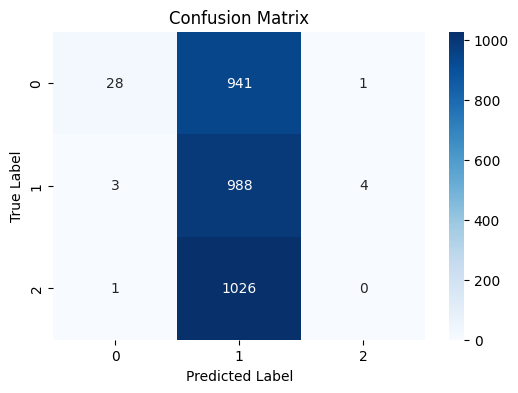

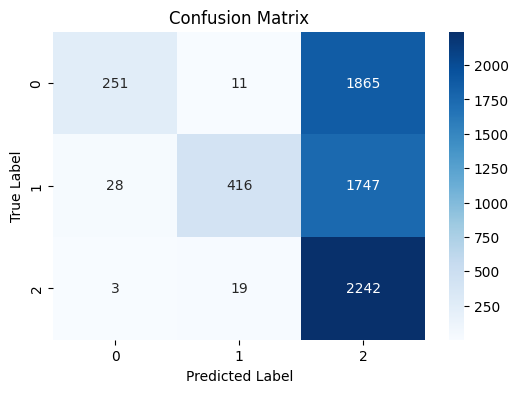

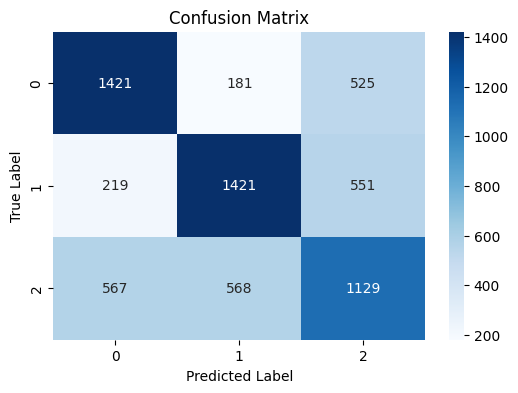

In [32]:
# Layout
dashboard = pn.Column(
    "# Model Performance & Confusion Matrix Dashboard",
    "## Adjust Data Distribution and Select Model",
    slider,
    model_selector,
    pn.bind(update_dashboard, scale_factor=slider, model_type=model_selector)
)

# Serve the dashboard
dashboard.servable()
